## Download de Dependências

In [ ]:
!pip install -r "/content/drive/MyDrive/2025.2/ANSM 2025-2 - Ernane Ferreira/work1/requirements.txt"

## Import de Dependências

In [ ]:
import segyio
import numpy as np
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from scipy.signal import hilbert
from scipy import ndimage
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
import pandas as pd
from tqdm import tqdm
import warnings

warnings.filterwarnings("ignore")

## Carregamento do Arquivo SGY

In [ ]:
# Definindo o path
filepath = "/content/drive/MyDrive/2025.2/ANSM 2025-2 - Ernane Ferreira/work1/data/raw/jequitinhonha.sgy"

def load_segy_manual_2d_final(filepath):
    """
    Carrega arquivo SEG-Y de linha 2D manualmente.
    A geometria é forçada para (n_traces, 1, n_samples) para compatibilidade
    com o cálculo de atributos (axis=2).
    """

    print(f"Carregando arquivo de linha 2D manualmente: {filepath}")

    try:
        with segyio.open(filepath, "r", ignore_geometry=True) as segyfile:

            n_traces = segyfile.tracecount
            n_samples = len(segyfile.samples)

            print(f"Traces totais: {n_traces}")
            print(f"Amostras por trace: {n_samples}")

            # 1. Leitura de todos os traces (MÉTODO DO LOOP LENTO)
            print("Lendo todos os traces via loop...")
            all_traces = np.zeros((n_traces, n_samples), dtype=segyfile.dtype)
            for i, trace in tqdm(enumerate(segyfile.trace), total=n_traces):
                all_traces[i] = trace

            # 2. DEFINIÇÃO DA GEOMETRIA (2D):
            # n_inlines = n_traces (o índice da linha agora é o índice do trace)
            # n_crosslines = 1 (apenas uma linha/seção, típica de dado 2D)
            n_inlines = n_traces
            n_crosslines = 1

            print(f"Geometria forçada: {n_inlines} traces x {n_crosslines} linha (2D)")

            # 3. Reshape forçado dos dados: (n_traces, 1, n_samples)
            data = all_traces.reshape(n_inlines, n_crosslines, n_samples)

            print(f"Dimensões finais: {data.shape}")

            # 4. Estatísticas
            print(f"Valores: min={np.min(data):.2f}, max={np.max(data):.2f}, mean={np.mean(data):.2f}")

            # 5. Criação dos arrays de labels
            inlines_idx = np.arange(n_inlines)
            crosslines_idx = np.arange(n_crosslines)

            return data, inlines_idx, crosslines_idx, segyfile.samples

    except Exception as e:
        print(f"ERRO CRÍTICO no carregamento: {e}")
        return None, None, None, None

# Carregar dados
seismic_data, inlines, crosslines, times = load_segy_manual_2d_final(filepath)

if seismic_data is not None:
    print(f"Volume Sísmico carregado com sucesso. Shape: {seismic_data.shape}")

Carregando arquivo de linha 2D manualmente: /content/drive/MyDrive/2025.2/ANSM 2025-2 - Ernane Ferreira/work1/data/raw/jequitinhonha.sgy
Traces totais: 12060
Amostras por trace: 1001
Lendo todos os traces via loop...


100%|██████████| 12060/12060 [00:01<00:00, 11843.29it/s]


Geometria forçada: 12060 traces x 1 linha (2D)
Dimensões finais: (12060, 1, 1001)
Valores: min=-429850624.00, max=358739968.00, mean=-223.29
Volume Sísmico carregado com sucesso. Shape: (12060, 1, 1001)


## Visualização da Ampliture (2D)
Carregamento manual.

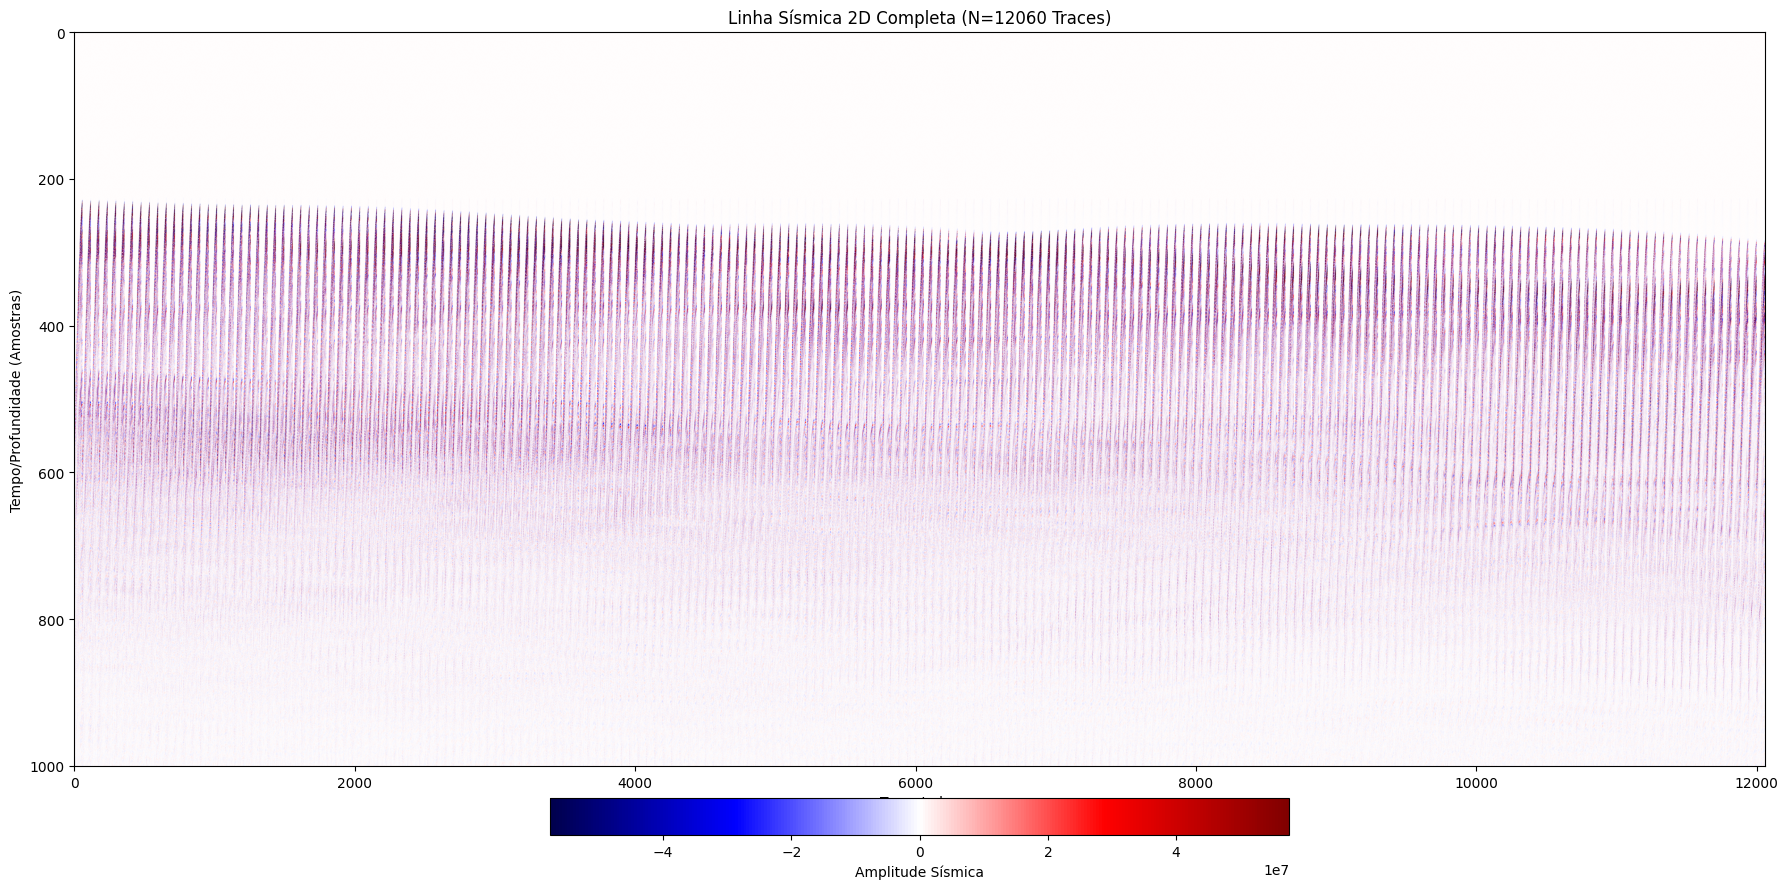

In [ ]:
if seismic_data is not None:

    # 1. ACHATAMENTO (FLATTEN) DO VOLUME 3D PARA 2D (N_TRACES x N_SAMPLES)
    # A dimensão do meio (Crosslines=1) é removida
    seismic_data_2d = seismic_data.reshape(-1, seismic_data.shape[2])

    fig, ax = plt.subplots(figsize=(18, 9))

    # Vmin/Vmax usam percentil para cortar ruído e melhorar o contraste
    v_limit = np.percentile(np.abs(seismic_data_2d), 99.5)

    # 2. Plotagem da Linha Sísmica 2D Completa
    im = ax.imshow(
        seismic_data_2d.T, # Transposta para Tempo/Profundidade no Eixo Y
        aspect='auto',
        cmap='seismic',
        vmin=-v_limit,
        vmax=v_limit
    )

    n_traces = seismic_data_2d.shape[0]
    ax.set_title(f"Linha Sísmica 2D Completa (N={n_traces} Traces)")
    ax.set_xlabel("Trace Index")
    ax.set_ylabel("Tempo/Profundidade (Amostras)")
    plt.colorbar(im, ax=ax, orientation='horizontal', fraction=0.046, pad=0.04, label="Amplitude Sísmica")

    plt.tight_layout()
    plt.show()

## Extração de Features

In [ ]:
if seismic_data is not None:

    print("--- Início da Extração de Atributos Sísmicos ---")

    # 1. Cálculo do Sinal Analítico (Transformada de Hilbert)
    analytical_signal = hilbert(seismic_data, axis=2) # axis=2 ainda é o eixo do tempo

    # 2. Extração do Envelope e Fase
    attribute_envelope = np.abs(analytical_signal)
    attribute_phase = np.arctan2(
        np.imag(analytical_signal),
        np.real(analytical_signal)
    )

    # 3. Criação da Matriz de Features (Voxel x Atributo)
    features_list = {
        'Amplitude': seismic_data,
        'Envelope': attribute_envelope,
        'Fase': attribute_phase
    }

    # Stack dos atributos e Reshape para (Total Voxels, N_Features)
    voxel_features = np.stack(list(features_list.values()), axis=-1)

    n_total_voxels = np.prod(seismic_data.shape)
    n_features = len(features_list)

    X = voxel_features.reshape(n_total_voxels, n_features) # matriz 2D de dados pronta para o K-means

    print("-" * 50)
    print(f"Matriz de Features (X) criada. Shape: {X.shape}")

    # 4. Normalização dos Dados
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    print(f"Dados escalonados com sucesso. Média de X_scaled: {np.mean(X_scaled):.2f}")
    print("--- Fim da Extração e Preparação de Features ---")
else:
    print("Dados sísmicos não carregados.")
    X_scaled = None

--- Início da Extração de Atributos Sísmicos ---
--------------------------------------------------
Matriz de Features (X) criada. Shape: (12072060, 3)
Dados escalonados com sucesso. Média de X_scaled: 0.00
--- Fim da Extração e Preparação de Features ---


## Avaliação e Escolha de K ideal - Método Silhouette

--- Avaliação do Número Ideal de Clusters (K) com Silhouette Score (Amostra 1.00%) ---
K=2: Silhouette Score (Amostra) = 0.5228
K=3: Silhouette Score (Amostra) = 0.5380
K=4: Silhouette Score (Amostra) = 0.5625
K=5: Silhouette Score (Amostra) = 0.5730
K=6: Silhouette Score (Amostra) = 0.5967
K=7: Silhouette Score (Amostra) = 0.5311
K=8: Silhouette Score (Amostra) = 0.5406
K=9: Silhouette Score (Amostra) = 0.5393

Melhor K: 6 com Silhouette Score: 0.5967


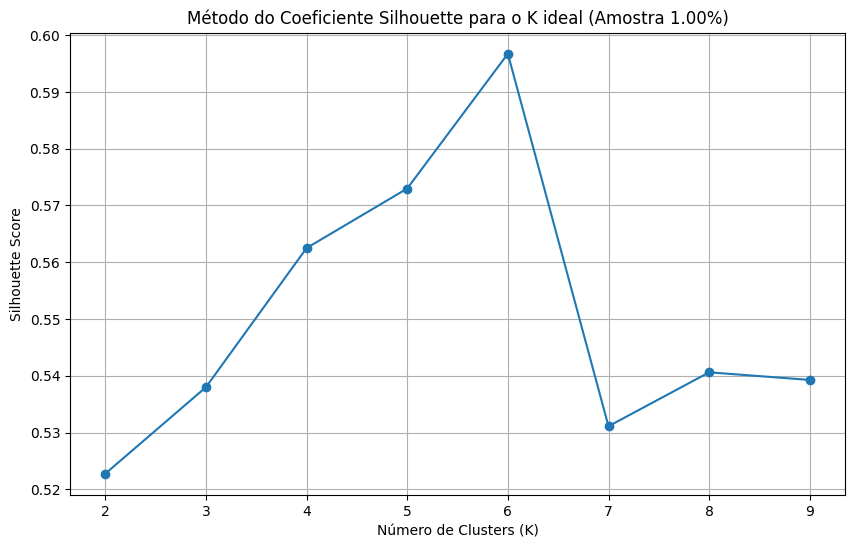

In [ ]:
if X_scaled is not None:

    from sklearn.model_selection import train_test_split
    import numpy as np

    # 1. Configuração e Amostragem
    SAMPLE_FRACTION = 0.01 # 1%

    # 2. Análise do Melhor K (Método Silhouette)
    K_range = range(2, 10)
    silhouette_scores = []

    print(f"--- Avaliação do Número Ideal de Clusters (K) com Silhouette Score (Amostra {(SAMPLE_FRACTION*100):.2f}%) ---")

    # Amostra inicial (X_sample_base) para agilizar TUDO
    X_sample_base, _, _, _ = train_test_split(
        X_scaled, X_scaled,
        train_size=SAMPLE_FRACTION,
        random_state=42,
        shuffle=True
    )

    for k in K_range:
        kmeans_model = KMeans(
            n_clusters=k,
            init='k-means++',
            n_init=10,
            random_state=42
        )
        kmeans_model.fit(X_sample_base)

        labels_sample = kmeans_model.labels_
        score = silhouette_score(X_sample_base, labels_sample)
        silhouette_scores.append(score)
        print(f"K={k}: Silhouette Score (Amostra) = {score:.4f}")

    # 3. Escolha do K ideal (maior silhouette score)
    best_k = K_range[np.argmax(silhouette_scores)]
    print(f"\nMelhor K: {best_k} com Silhouette Score: {max(silhouette_scores):.4f}")

    # 4. Plotagem dos Scores
    plt.figure(figsize=(10, 6))
    plt.plot(K_range, silhouette_scores, marker='o')
    plt.title(f"Método do Coeficiente Silhouette para o K ideal (Amostra {(SAMPLE_FRACTION*100):.2f}%)")
    plt.xlabel("Número de Clusters (K)")
    plt.ylabel("Silhouette Score")
    plt.grid(True)
    plt.show()

else:
    print("Dados não prontos para o K-means.")

## Classificação Final

In [ ]:
# 1. Utilizando o K ideal (>>> Silhouette Score)
try:
    K_IDEAL = best_k
except NameError:
    print("Aviso: Variável 'best_k' não encontrada. Usando K=6 como fallback.")
    K_IDEAL = 6


print(f"\n--- Classificação Final do Volume COMPLETO com K = {K_IDEAL} ---")

# 2. Treinamento Final Otimizado:
final_kmeans = KMeans(n_clusters=K_IDEAL, init='k-means++', n_init=10, random_state=42)
final_kmeans.fit(X_sample_base)

# 3. classificação em todo o dataset
print("Classificando todos os voxels do volume completo...")
cluster_labels_flat = final_kmeans.predict(X_scaled)

# 6. Reshape dos Labels: Mantém o shape (N_TRACES, 1, N_SAMPLES)
segmentation_volume = cluster_labels_flat.reshape(seismic_data.shape)

print(f"Segmentação concluída. Volume de Labels criado. Shape: {segmentation_volume.shape}")


--- Classificação Final do Volume COMPLETO com K = 6 ---
Classificando todos os voxels do volume completo...
Segmentação concluída. Volume de Labels criado. Shape: (12060, 1, 1001)


## Visualização Interativa da Segmentação (2D)

In [ ]:
if 'segmentation_volume' in locals():

    # 1. ACHATAMENTO (FLATTEN) DOS VOLUMES 3D PARA 2D
    n_samples = seismic_data.shape[2]
    # seismic_data tem shape (N_TRACES, 1, N_SAMPLES) -> reshape para (N_TRACES, N_SAMPLES)
    seismic_data_2d = seismic_data.reshape(-1, n_samples)
    segmentation_volume_2d = segmentation_volume.reshape(-1, n_samples)
    n_traces = seismic_data_2d.shape[0]

    from plotly.subplots import make_subplots
    import matplotlib.pyplot as plt
    import plotly.graph_objects as go
    import numpy as np

    # 2. Configuração de Cores (igual à anterior)
    cmap_spectral = plt.cm.get_cmap('Spectral', K_IDEAL)
    plotly_colorscale = [
        [i / (K_IDEAL - 1),
         f'rgb({int(r*255)},{int(g*255)},{int(b*255)})']
        for i, (r, g, b, a) in enumerate(cmap_spectral(np.arange(K_IDEAL)))
    ]

    # 3. Plotagem Lado a Lado (Amplitude vs. Segmentação)
    fig = make_subplots(
        rows=1, cols=2,
        subplot_titles=(
            f"Linha Sísmica 2D - Amplitude (Original)",
            f"Linha Sísmica 2D - Segmentação K-means (K={K_IDEAL})"
        )
    )

    # Gráfico 1: Amplitude Sísmica (2D)
    v_limit = np.percentile(np.abs(seismic_data_2d), 99.5)
    fig.add_trace(go.Heatmap(
        z=seismic_data_2d.T, # Transposta para Tempo/Profundidade no Eixo Y
        colorscale='RdBu_r',
        zmin=-v_limit,
        zmax=v_limit,
        showscale=False
    ), row=1, col=1)

    # Gráfico 2: Segmentação K-means (2D)
    fig.add_trace(go.Heatmap(
        z=segmentation_volume_2d.T, # Transposta para Tempo/Profundidade no Eixo Y
        colorscale=plotly_colorscale,
        zmin=0,
        zmax=K_IDEAL - 1,
        colorbar=dict(
            title="Cluster ID",
            tickvals=list(range(K_IDEAL)),
            ticktext=[f"Fácies {i}" for i in range(K_IDEAL)],
        ),
        showscale=True
    ), row=1, col=2)

    # 4. Ajustes finais no layout
    fig.update_layout(
        title_text="Segmentação de Fácies Sísmicas (Linha 2D Completa)",
        height=700
    )
    # Rótulos do eixo X (Trace Index)
    fig.update_xaxes(title_text=f"Trace Index (0 a {n_traces - 1})")
    fig.update_yaxes(title_text="Tempo/Profundidade (Amostras)", autorange="reversed")

    fig.show()

## Caracterização dos Centroids

--- Centroids de Atributos Sísmicos por Fácies (K=6) ---
 (Valores Originais de Amplitude, Envelope e Fase em Radianos/Escala Padronizada)
----------------------------------------------------------------------
               Amplitude      Envelope  Fase  % Volume Total
Cluster ID                                                  
0          -2.800432e+05  2.533953e+06  1.47           49.51
1          -3.558488e+05  2.563958e+06 -1.62           45.12
2          -3.236296e+07  5.029383e+07 -0.20            1.38
3           7.956835e+07  1.150188e+08 -0.06            0.33
4           1.751354e+07  2.689065e+07 -0.02            3.52
5          -1.433149e+08  1.697672e+08  0.11            0.12
----------------------------------------------------------------------


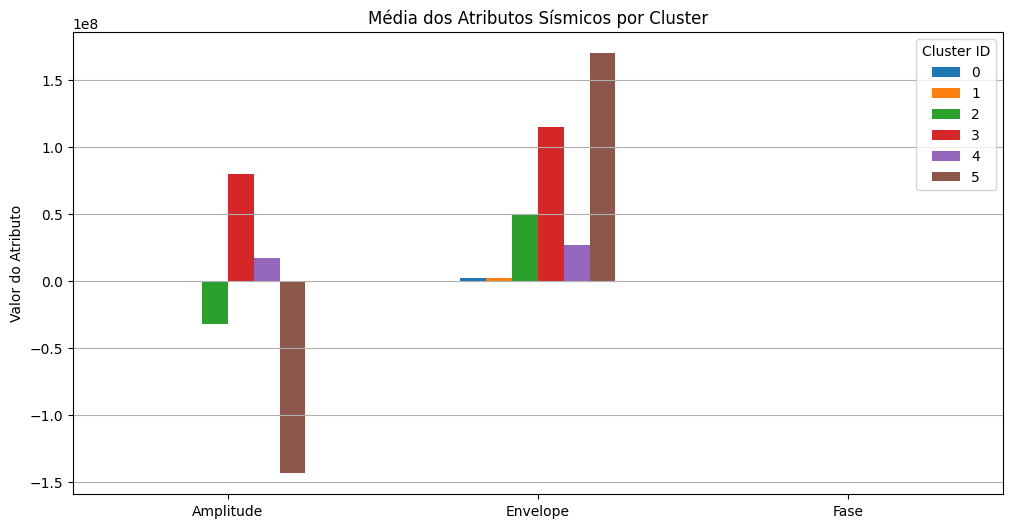

In [ ]:
if 'final_kmeans' in locals():

    feature_names = ['Amplitude', 'Envelope', 'Fase']

    # 1. Obter os Centroids (nos dados escalonados)
    centroids_scaled = final_kmeans.cluster_centers_

    # 2. Reverter os Centroids para a Escala Original (Melhor para Interpretação)
    try:
        centroids_original_scale = scaler.inverse_transform(centroids_scaled)
    except NameError:
        print("Aviso: Variável 'scaler' não encontrada. Usando Centroids em escala padronizada.")
        centroids_original_scale = centroids_scaled
        feature_names = [f'Scaled {f}' for f in feature_names]


    # 3. Criar o DataFrame de Caracterização
    df_centroids = pd.DataFrame(centroids_original_scale, columns=feature_names)
    df_centroids.index.name = 'Cluster ID'

    # 4. Calcular o Percentual de Cada Fácies no Volume COMPLETO
    cluster_counts = pd.Series(cluster_labels_flat).value_counts().sort_index()
    total_voxels = cluster_counts.sum()
    df_centroids['% Volume Total'] = (cluster_counts / total_voxels) * 100

    print(f"--- Centroids de Atributos Sísmicos por Fácies (K={K_IDEAL}) ---")
    print(" (Valores Originais de Amplitude, Envelope e Fase em Radianos/Escala Padronizada)")
    print("-" * 70)
    print(df_centroids.round(2))
    print("-" * 70)

    # 5. Plotagem para comparação visual dos atributos
    df_centroids[feature_names].T.plot(kind='bar', figsize=(12, 6))
    plt.title("Média dos Atributos Sísmicos por Cluster")
    plt.ylabel("Valor do Atributo")
    plt.xticks(rotation=0)
    plt.grid(axis='y')
    plt.show()

else:
    print("Modelo K-means não encontrado. Verifique se a Classificação Final rodou com sucesso.")

### Interpretação (K=6 Fácies) (@TODO?)

A separação de $K=6$ dividiu as fácies de alta energia/anomalia em unidades mais detalhadas.

| Cluster ID | % Volume | Amplitude Média | Envelope Média | Fase Média | Interpretação Final (K=6) |
| :--- | :--- | :--- | :--- | :--- | :--- |
| **0** | **49.51%** | Baixa Negativa | Baixa (2.5M) | Alta Positiva (1.47) | **Matriz 1:** Metade do *background*. Sutil Amplitude negativa com fase variável. |
| **1** | **45.12%** | Baixa Negativa | Baixa (2.5M) | Negativa Extrema (-1.62) | **Matriz 2:** A outra metade do *background*. Praticamente idêntica à 0 em energia, mas com fase oposta. Juntas, formam 94.6% do volume. |
| **2** | 1.38% | Média Negativa | Média-Alta (50M) | Neutra (-0.20) | **Fronteira/Selo 1:** Média energia e fase estável. Pode ser a rocha de selo acima de um reservatório ou rocha transicional. |
| **3** | 0.33% | **Alta Positiva (80M)** | **Alta (115M)** | Neutra (-0.06) | **RESERVATÓRIO POTENCIAL 1:** A Fácies com a maior Amplitude positiva e alta energia. O alvo mais promissor (Pico de Reflexão). |
| **4** | **3.52%** | Média Positiva (17M) | Média (27M) | Neutra (-0.02) | **RESERVATÓRIO POTENCIAL 2:** Um alvo de qualidade inferior (menos energia) ou uma zona de contorno/sombra do alvo principal 3. |
| **5** | **0.12%** | **Negativa Extrema (-143M)** | **Extrema (170M)** | Neutra (0.11) | **ANOMALIA (Contato Fluido):** Menor volume, mas energia máxima. Amplitude negativa extrema. O perfil clássico de um *flat spot* ou anomalia estrutural rara. |

O K-means com $K=6$ detalhou as fácies de alto potencial (os $\approx 5\%$ do volume) em unidades mais gerenciáveis (Reservatório 1, Reservatório 2, Selo e Anomalia).